In [1]:
import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Problem data
reservations = np.array([110, 118, 103, 161, 140])
flight_capacities = np.array([100, 100, 100, 150, 150])
cost_per_hour = 50
cost_external_company = 75

In [3]:
# Build transportation grah
G = nx.DiGraph()

# Add nodes
G.add_node(0, supply=reservations[0], label="10am")
G.add_node(1, supply=reservations[1], label="12pm")
G.add_node(2, supply=reservations[2], label="2pm")
G.add_node(3, supply=reservations[3], label="4pm")
G.add_node(4, supply=reservations[4], label="6pm")
G.add_node(5, supply=0, label="9pm")
G.add_node(6, supply=-np.sum(reservations), label="NY")

# Edges
M = 1000

# From 10am
G.add_edge(0, 1, cost=2 * cost_per_hour, capacity=M)
G.add_edge(0, 2, cost=4 * cost_per_hour, capacity=M)
G.add_edge(0, 3, cost=6 * cost_per_hour, capacity=M)
G.add_edge(0, 4, cost=8 * cost_per_hour, capacity=M)
G.add_edge(0, 5, cost=11 * cost_per_hour + cost_external_company, capacity=M)
G.add_edge(0, 6, cost=0, capacity=flight_capacities[0])

# From 12pm
G.add_edge(1, 2, cost=2 * cost_per_hour, capacity=M)
G.add_edge(1, 3, cost=4 * cost_per_hour, capacity=M)
G.add_edge(1, 4, cost=6 * cost_per_hour, capacity=M)
G.add_edge(1, 5, cost=9 * cost_per_hour + cost_external_company, capacity=M)
G.add_edge(1, 6, cost=0, capacity=flight_capacities[1])

# From 2pm
G.add_edge(2, 3, cost=2 * cost_per_hour, capacity=M)
G.add_edge(2, 4, cost=4 * cost_per_hour, capacity=M)
G.add_edge(2, 5, cost=7 * cost_per_hour + cost_external_company, capacity=M)
G.add_edge(2, 6, cost=0, capacity=flight_capacities[2])

# From 4pm
G.add_edge(3, 4, cost=2 * cost_per_hour, capacity=M)
G.add_edge(3, 5, cost=5 * cost_per_hour + cost_external_company, capacity=M)
G.add_edge(3, 6, cost=0, capacity=flight_capacities[3])

# From 6pm
G.add_edge(4, 5, cost=3 * cost_per_hour + cost_external_company, capacity=M)
G.add_edge(4, 6, cost=0, capacity=flight_capacities[4])

# From 9pm
G.add_edge(5, 6, cost=0, capacity=M)

In [4]:
# Note minus sign for convention
# In our formulation:
# -> 1 means arc exits node
# -> -1 means arc enters node
A = -nx.linalg.graphmatrix.incidence_matrix(G, oriented=True)
print("A =\n", A.todense())

A =
 [[ 1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0.  0.  1.  1.  1.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0. -1.  0.  0.
   1.  1.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0. -1.  0.
  -1.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0. -1.
   0. -1. -1.]]


In [5]:
# Get weights, capacities, and supply vectors
c = np.array([G[u][v]['cost'] for u,v in G.edges])
u = np.array([G[u][v]['capacity'] for u,v in G.edges])
b = np.array([G.nodes[u]['supply'] for u in G.nodes])

In [6]:
# Solve airline problem
# Note: you need to install GLPK. It is part of CVXOPT.
# Just run:
# pip install cvxopt
# 
# GLPK runs a simple method, which, as you know, returns exactly integral 
# solutions at vertices. Other solvers such as ECOS use interior-point methods 
# and they return slightly imprecise solutions that are not exactly integral.
x = cp.Variable(len(G.edges))
objective = cp.Minimize(c @ x)
constraints = [A @ x == b, 0 <= x, x <= u]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.GLPK)
print("Optimal cost = $", problem.objective.value)

Optimal cost = $ 18300.0


In [7]:
# Show solution
# Note: some bounds/capacities are not integral -> Solution not integral
print("x = ", x.value)

x =  [  0.   0.   0.  10.   0. 100.   0.   0.   0.  18. 100.   0.   0.   3.
 100.   0.  11. 150.   0. 150.  32.]


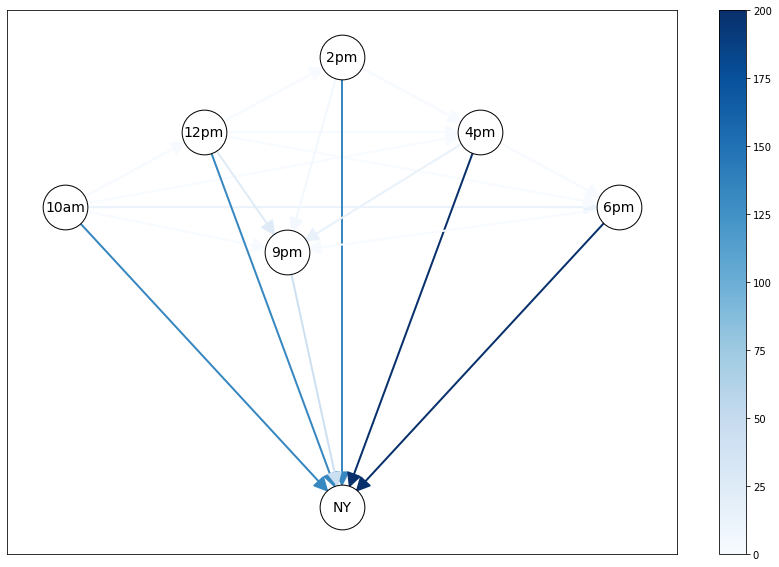

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cmap = plt.cm.Blues

# Positions in 2d plot
layout = {0: np.array([0.0, 0.0]),
          1: np.array([1.0, 0.5]),
          2: np.array([2.0, 1.0]),
          3: np.array([3.0, 0.5]),
          4: np.array([4.0, 0.0]),
          5: np.array([1.6, -0.3]),
          6: np.array([2.0, -2.0]),
         }
nx.draw_networkx_nodes(G, layout, node_color='w', edgecolors='k', node_size=2000)
nx.draw_networkx_edges(G, layout, edge_cmap=cmap, edge_color=x.value, 
                       width=2, arrowsize=30, min_target_margin=20)

labels = {u: G.nodes[u]['label'] for u in G.nodes}
nx.draw_networkx_labels(G,layout,labels,font_size=14)

# Print colormap
sm = plt.cm.ScalarMappable(cmap=cmap, 
                           norm=plt.Normalize(vmin=0, vmax=200)
                          )
cbar = plt.colorbar(sm)

plt.show()